In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import time

In [25]:
# Cell 2: U-Net Building Blocks
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

class UNet1D(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[16, 32, 64, 128]):
        super().__init__()
        
        self.downs = nn.ModuleList()  # Encoder blocks (downsampling path)
        self.ups = nn.ModuleList()    # Decoder blocks (upsampling path)
    
        # ----- Encoder: Downsampling Path -----
        # Each ConvBlock halves the temporal resolution via pooling (done in forward),
        # and increases the number of feature channels.
        for feat in features:
            self.downs.append(ConvBlock(in_channels, feat))  # ConvBlock: Conv + ReLU + Conv + ReLU
            in_channels = feat  # Update in_channels for the next block
    
        # ----- Bottleneck -----
        # Deepest layer in the U-Net, connects encoder and decoder
        self.bottleneck = ConvBlock(features[-1], features[-1]*2)
    
        # ----- Decoder: Upsampling Path -----
        # Reverse features list for symmetrical decoder
        rev_feats = features[::-1]
        for feat in rev_feats:
            # First upsample (via transposed convolution)
            self.ups.append(
                nn.ConvTranspose1d(feat*2, feat, kernel_size=2, stride=2)
            )
            # Then apply ConvBlock: input has double channels due to skip connection
            self.ups.append(ConvBlock(feat*2, feat))
    
        # ----- Final Output Convolution -----
        # 1x1 convolution to map to desired output channels (e.g., P, S, noise)
        self.final_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = F.max_pool1d(x, kernel_size=2)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_conn = skip_connections[idx//2]
            if x.shape[-1] != skip_conn.shape[-1]:
                x = F.pad(x, (0, skip_conn.shape[-1] - x.shape[-1]))
            x = torch.cat((skip_conn, x), dim=1)
            x = self.ups[idx+1](x)
        x = self.final_conv(x)
        return F.softmax(x, dim=1)

In [26]:
model = UNet1D()

In [27]:
from torchinfo import summary
summary(model, input_size=(1, 3, 3001))

Layer (type:depth-idx)                   Output Shape              Param #
UNet1D                                   [1, 3, 3001]              --
├─ModuleList: 1-1                        --                        --
│    └─ConvBlock: 2-1                    [1, 16, 3001]             --
│    │    └─Sequential: 3-1              [1, 16, 3001]             944
│    └─ConvBlock: 2-2                    [1, 32, 1500]             --
│    │    └─Sequential: 3-2              [1, 32, 1500]             4,672
│    └─ConvBlock: 2-3                    [1, 64, 750]              --
│    │    └─Sequential: 3-3              [1, 64, 750]              18,560
│    └─ConvBlock: 2-4                    [1, 128, 375]             --
│    │    └─Sequential: 3-4              [1, 128, 375]             73,984
├─ConvBlock: 1-2                         [1, 256, 187]             --
│    └─Sequential: 2-5                   [1, 256, 187]             --
│    │    └─Conv1d: 3-5                  [1, 256, 187]             98,560

# prepare data

In [28]:
import seisbench.data as sbd

# Load the dataset from the current directory
data = sbd.WaveformDataset("./dataset_full/")
print(data)

2025-04-10 12:02:40,864 | seisbench | WARNING | Dimension order not specified in data set. Assuming CW.
2025-04-10 12:02:42,371 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.
2025-04-10 12:02:42,371 | seisbench | WARNING | Default output component order 'ZNE' does not match dataset component order 'ENZ'. Please make sure this is intended.


Unnamed dataset - 183909 traces


In [29]:
data.metadata

,index,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_type,source_depth_km,preferred_source_magnitude,preferred_source_magnitude_type,preferred_source_magnitude_uncertainty,...,source_local_magnitude,source_local_magnitude_uncertainty,source_duration_magnitude,source_duration_magnitude_uncertainty,source_hand_magnitude,trace_missing_channel,trace_has_offset,split,trace_chunk,trace_component_order
0,0,uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.520,earthquake,14.907,2.10,md,0.030,...,NaN,NaN,2.10,0.030,NaN,0,1,train,,ENZ
1,1,uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.520,earthquake,14.907,2.10,md,0.030,...,NaN,NaN,2.10,0.030,NaN,2,0,train,,ENZ
2,2,uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.520,earthquake,14.907,2.10,md,0.030,...,NaN,NaN,2.10,0.030,NaN,0,1,train,,ENZ
3,3,uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.520,earthquake,14.907,2.10,md,0.030,...,NaN,NaN,2.10,0.030,NaN,2,0,train,,ENZ
4,4,uw10568748,2002-09-26T07:00:04.860000Z,48.481,-123.133,earthquake,22.748,2.90,md,0.030,...,NaN,NaN,2.90,0.030,NaN,0,1,train,,ENZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183904,183904,uw61802032,2022-01-15T01:30:38.770000Z,48.617,-123.032,earthquake,12.410,0.26,md,0.416,...,NaN,NaN,0.26,0.416,NaN,0,0,dev,,ENZ
183905,183905,uw61802032,2022-01-15T01:30:38.770000Z,48.617,-123.032,earthquake,12.410,0.26,md,0.416,...,NaN,NaN,0.26,0.416,NaN,0,0,train,,ENZ
183906,183906,uw61802032,2022-01-15T01:30:38.770000Z,48.617,-123.032,earthquake,12.410,0.26,md,0.416,...,NaN,NaN,0.26,0.416,NaN,0,0,train,,ENZ
183907,183907,uw61802032,2022-01-15T01:30:38.770000Z,48.617,-123.032,earthquake,12.410,0.26,md,0.416,...,NaN,NaN,0.26,0.416,NaN,0,0,train,,ENZ


In [30]:
from torch.utils.data import random_split, DataLoader
import seisbench.generate as sbg

train = data.train()
val = data.dev()
test = data.test()

In [31]:
phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_pP_arrival_sample": "P",
    "trace_P_arrival_sample": "P",
    "trace_P1_arrival_sample": "P",
    "trace_Pg_arrival_sample": "P",
    "trace_Pn_arrival_sample": "P",
    "trace_PmP_arrival_sample": "P",
    "trace_pwP_arrival_sample": "P",
    "trace_pwPm_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
    "trace_S_arrival_sample": "S",
    "trace_S1_arrival_sample": "S",
    "trace_Sg_arrival_sample": "S",
    "trace_SmS_arrival_sample": "S",
    "trace_Sn_arrival_sample": "S",
}
model_labels = ["P", "S", "noise"]

train_generator = sbg.GenericGenerator(train)
val_generator = sbg.GenericGenerator(val)
test_generator = sbg.GenericGenerator(test)

augmentations = [
    sbg.WindowAroundSample(
        list(phase_dict.keys()), samples_before=3000, windowlen=6000,
        selection="random", strategy="variable"
    ),
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, model_labels=model_labels, sigma=30, dim=0)
]

train_generator.add_augmentations(augmentations)
val_generator.add_augmentations(augmentations)
test_generator.add_augmentations(augmentations)

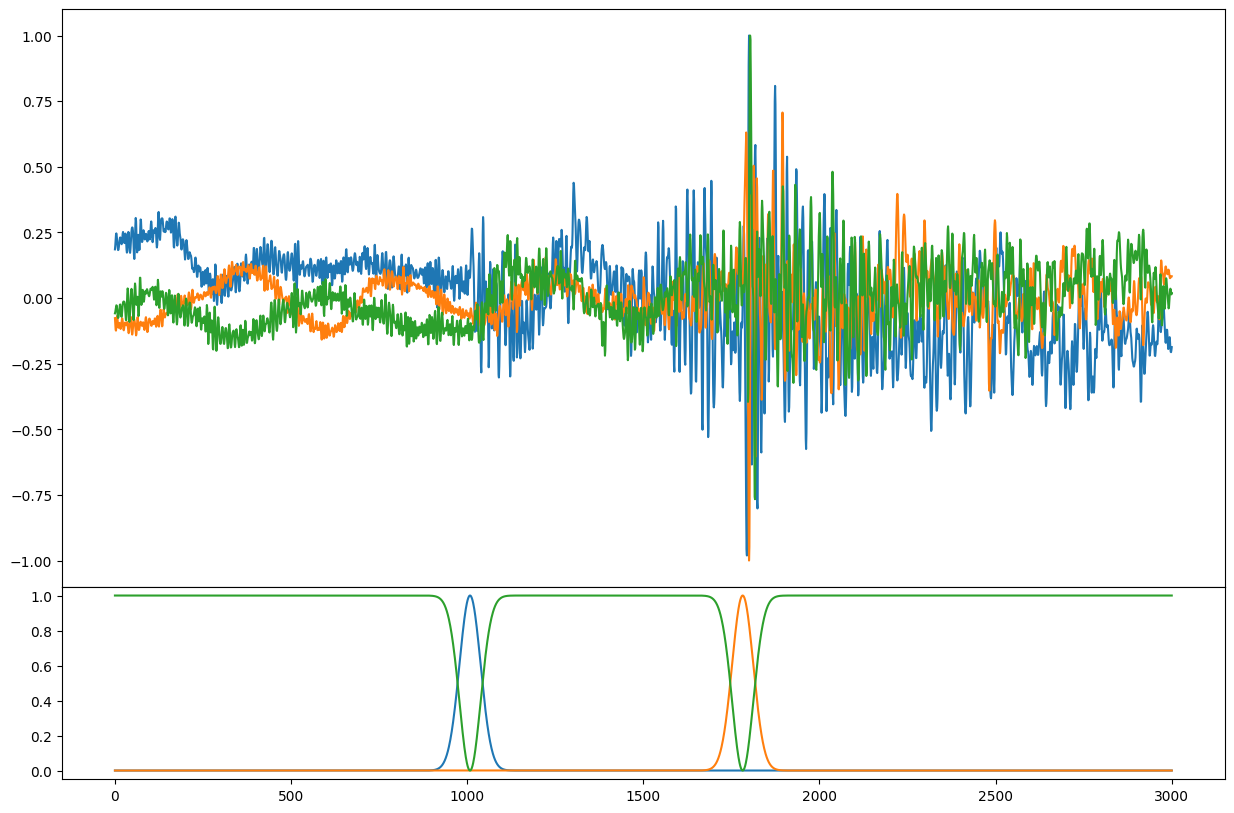

In [32]:
sample = train_generator[np.random.randint(len(train_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

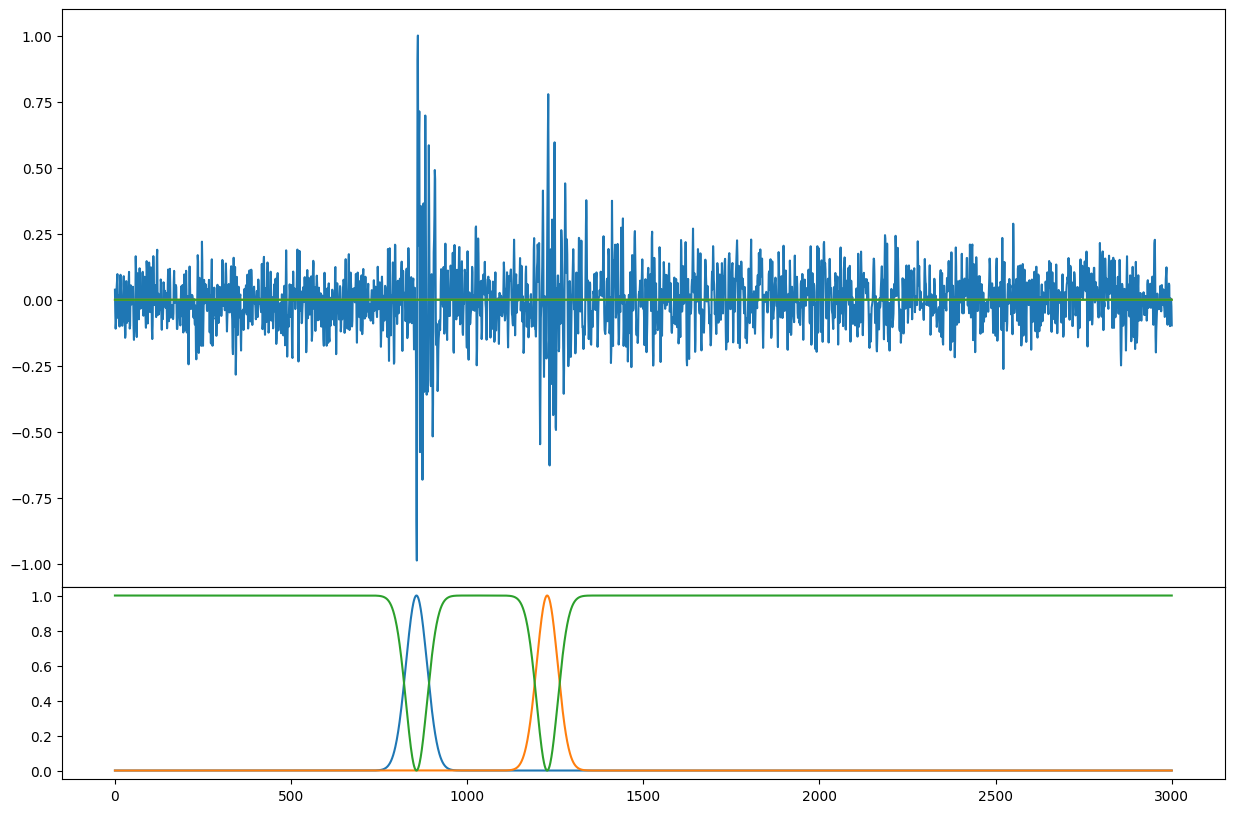

In [33]:
sample = val_generator[np.random.randint(len(val_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

In [34]:
from seisbench.util import worker_seeding

batch_size = 256
num_workers = 4  # The number of threads used for loading data

train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding)
val_loader = DataLoader(val_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)
test_loader = DataLoader(test_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)

# training

In [35]:
def loss_fn(y_pred, y_true, eps=1e-5):
    # vector cross entropy loss
    h = y_true * torch.log(y_pred + eps)
    h = h.mean(-1).sum(-1)  # Mean along sample dimension and sum along pick dimension
    h = h.mean()  # Mean over batch axis
    return -h

In [36]:
class EarlyStopper:
    """
    A class for early stopping the training process when the validation loss stops improving.

    Parameters:
    -----------
    patience : int, optional (default=1)
        The number of epochs with no improvement in validation loss after which training will be stopped.
    min_delta : float, optional (default=0)
        The minimum change in the validation loss required to qualify as an improvement.
    """

    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        """
        Check if the training process should be stopped.

        Parameters:
        -----------
        validation_loss : float
            The current validation loss.

        Returns:
        --------
        stop : bool
            Whether the training process should be stopped or not.
        """
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [37]:
def train_loop(model, dataloader, optimizer):
    mean_loss = 0
    model.train()
    size = len(dataloader.dataset)
    for batch_id, batch in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(batch["X"].to(device))
        loss = loss_fn(pred, batch["y"].to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_id % 5 == 0:
            loss, current = loss.item(), batch_id * batch["X"].shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            mean_loss += loss
    
    return mean_loss/size

def test_loop(model, dataloader):
    num_batches = len(dataloader)
    test_loss = 0

    model.eval()  # close the model for evaluation

    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch["X"].to(device))
            test_loss += loss_fn(pred, batch["y"].to(device)).item()

    test_loss /= num_batches
    print(f"Test avg loss: {test_loss:>8f} \n")
    return test_loss

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device {device}")
model = UNet1D().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
nb_epoch = 100
loss_train = []
loss_val = []
best_loss = 100 # init at something super high so 1st eval is best
best_epoch = 0
early_stopper = EarlyStopper(patience=1, min_delta=0.0)
model_name = "phasenet_style"
PATH_CHECKPOINT = f"./checkpoint/{model_name}.pt"
log_counter = 1

print("\n=== Training Configuration Recap ===")
print(f"Device: {device}")
print(f"Model: {model_name}")
print(f"Checkpoint Path: {PATH_CHECKPOINT}")
print(f"Optimizer: Adam")
print(f"Learning Rate: {optimizer.param_groups[0]['lr']}")
print(f"Epochs: {nb_epoch}")
print(f"Early Stopping Patience: {early_stopper.patience}")
print(f"Early Stopping Min Delta: {early_stopper.min_delta}")
print("====================================\n")

device cuda

=== Training Configuration Recap ===
Device: cuda
Model: phasenet_style
Checkpoint Path: ./checkpoint/phasenet_style.pt
Optimizer: Adam
Learning Rate: 0.001
Epochs: 100
Early Stopping Patience: 1
Early Stopping Min Delta: 0.0



In [39]:
start_time = time.perf_counter()
print(f"training starting, nb epoch={nb_epoch}")
for epoch in range(nb_epoch):
    loss_train.append(train_loop(model, train_loader, optimizer))
    loss_val.append(test_loop(model, val_loader))

    if loss_val[-1] < best_loss:
        best_loss = loss_val[-1]
        best_epoch = epoch
        torch.save(model.state_dict(), PATH_CHECKPOINT)
    if early_stopper.early_stop(loss_val[-1]):
        print(f"early stopping at epoch {epoch}: train loss={loss_train[-1]}, val loss={loss_val[-1]}")
        break
    if epoch % log_counter == 0:
        print(f"Epoch {epoch}: train loss={loss_train[-1]:.6f}, val loss={loss_val[-1]:.6f}")
        print(f"Best loss={best_loss} at epoch {best_epoch}")
        print(f"average time per epoch {(time.perf_counter() - start_time) / log_counter:.2f}")
        print("\n ##################### \n")
        start_time = time.perf_counter()

training starting, nb epoch=100
loss: 1.154559  [    0/147127]
loss: 1.121764  [ 1280/147127]
loss: 1.074612  [ 2560/147127]
loss: 0.937781  [ 3840/147127]
loss: 0.455750  [ 5120/147127]
loss: 0.245227  [ 6400/147127]
loss: 0.230135  [ 7680/147127]
loss: 0.228901  [ 8960/147127]
loss: 0.230223  [10240/147127]
loss: 0.230634  [11520/147127]
loss: 0.222739  [12800/147127]
loss: 0.220764  [14080/147127]
loss: 0.220517  [15360/147127]
loss: 0.221513  [16640/147127]
loss: 0.218417  [17920/147127]
loss: 0.218923  [19200/147127]
loss: 0.215396  [20480/147127]
loss: 0.218917  [21760/147127]
loss: 0.214089  [23040/147127]
loss: 0.217982  [24320/147127]
loss: 0.218198  [25600/147127]
loss: 0.219793  [26880/147127]
loss: 0.216203  [28160/147127]
loss: 0.212585  [29440/147127]
loss: 0.209593  [30720/147127]
loss: 0.211875  [32000/147127]
loss: 0.206837  [33280/147127]
loss: 0.200449  [34560/147127]
loss: 0.195442  [35840/147127]
loss: 0.194229  [37120/147127]
loss: 0.185266  [38400/147127]
loss: 0

In [40]:
print(f"training finished, restoring best weights")
model.load_state_dict(torch.load(PATH_CHECKPOINT, map_location=device))
print(f"best loss={best_loss}, model eval loss={test_loop(model, val_loader)} at epoch {best_epoch}")

training finished, restoring best weights
Test avg loss: 0.067408 

best loss=0.06754201817989271, model eval loss=0.06740818483794729 at epoch 4


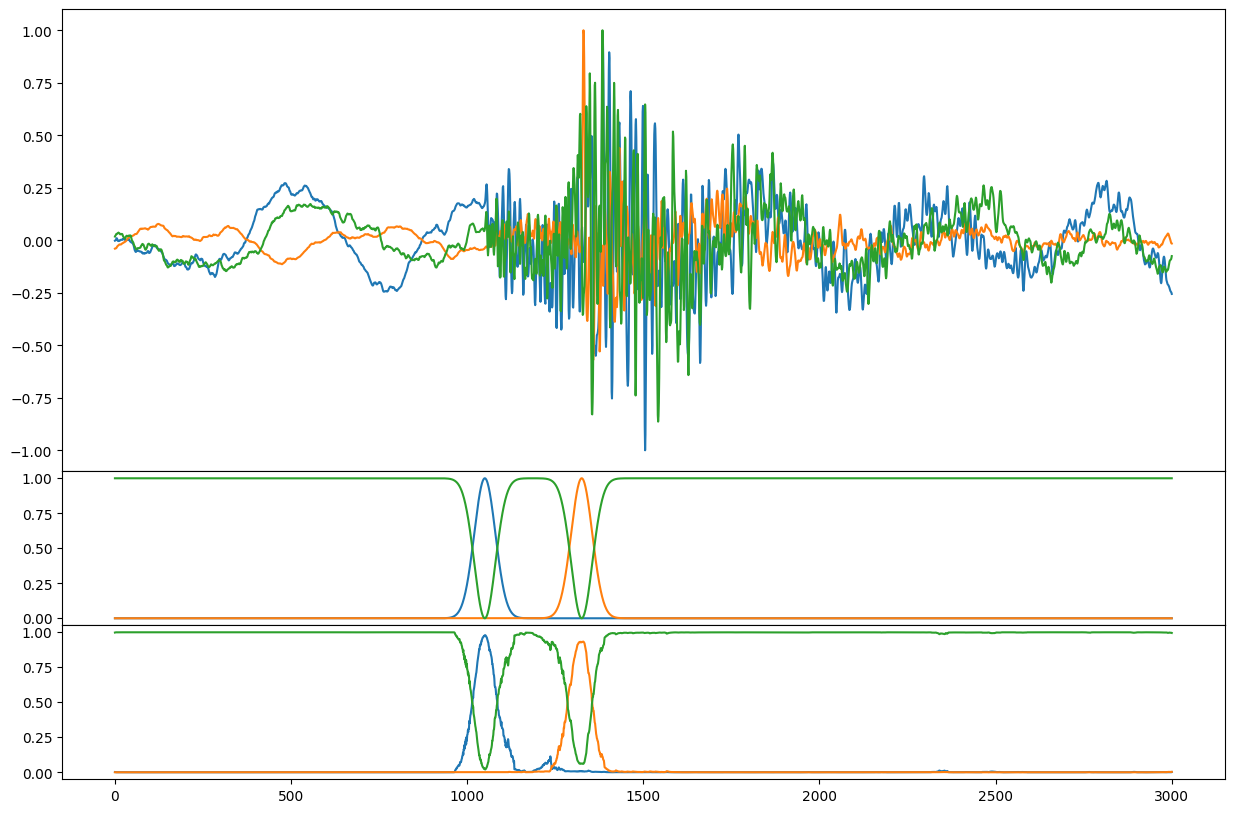

In [41]:
sample = test_generator[np.random.randint(len(test_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

model.eval()  # close the model for evaluation

with torch.no_grad():
    pred = model(torch.tensor(sample["X"], device=device).unsqueeze(0))  # Add a fake batch dimension
    pred = pred[0].cpu().numpy()

axs[2].plot(pred.T)

In [42]:
torch.save(model.state_dict(), "model_weights.pt")
torch.save(model, "fullmodel_with_architacture.pt")

# Load model for ref

In [43]:
model = UNet1D()
model.load_state_dict(torch.load("model_weights.pt"))
model.eval()  # set to eval mode for inference

UNet1D(
  (downs): ModuleList(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(3, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
      )
    )
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
      )
    )
    (2): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
      )
    )
    (3): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU